# Pregunta 3: Convolutional Neural Network (CNN) en CIFAR.

a) Construya una función que cargue todos los bloques de entrenamiento y pruebas del problema CIFAR generando como salida: (i) dos matrices $X_{tr}$, $Y_{tr}$, correspondientes a las imágenes y etiquetas de entrenamiento, (ii) dos matrices $X_t$ , $Y_t$ , correspondientes a las imágenes y etiquetas de pruebas, y finalmente (iii) dos matrices $X_v$,$Y_v$, correspondientes a imágenes y etiquetas que se usarán como conjunto de validación, es decir para tomar decisiones de diseño acerca del modelo. Este último conjunto debe ser extraı́do desde el conjunto de entrenamiento original y no debe superar las 5000 imágenes.

Se hace un shuffle y se sacan los ultimos 5000 desde el entrenamiento para hacer el conjunto de validación

In [119]:
import pickle
import numpy as np
import os
from scipy.misc import imread
import math
import matplotlib.pyplot as plt
import pydot_ng as pydot 
from IPython.display import Image, display, SVG

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
from keras.utils import plot_model


In [32]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def load_CIFAR_one(filename):
    with open(filename, 'rb') as f:
        #print("f: ",f)
        datadict = pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        Y = np.array(Y)
        return X, Y
    
def load_CIFAR10(PATH):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(PATH, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_one(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
#     print(len(Xtr))
#     print(len(Ytr))
    #add your Xval
    XY = list(zip(Xtr, Ytr))
    np.random.shuffle(XY)
    Xtr, Ytr = zip(*XY)
    msk = 45000
    Xva = np.array(Xtr[msk:])
    Yva = np.array(Ytr[msk:])   
    Xtr = np.array(Xtr[:msk])        
    Ytr = np.array(Ytr[:msk])
#     print(len(Xtr))
#     print(len(Ytr))
#     print(len(Xva))
#     print(len(Yva))
        
    del X, Y
    Xte, Yte = load_CIFAR_one(os.path.join(PATH, 'test_batch'))
    return Xtr, Ytr, Xva, Yva, Xte, Yte

In [36]:
x_train, y_train, x_val, y_val, x_test, y_test = load_CIFAR10('.')

seria bueno visualizar las imagenes~

b) Prepare subconjuntos de entrenamiento, validación y pruebas normalizando las imágenes de entrenamiento y pruebas, dividiendo las intensidades originales de pixel en cada canal por 255. Es importante recordar que ahora se trabajará con la estructura original de los datos, por lo que es necesario recuperar la forma original de las imágenes del vector en el archivo en que vienen. Además, si desea trabajar con el orden de las dimensiones denominado ’tf’ (por defecto para TensorFlow) deberá hacer realizar la transposición correspondiente. Finalmente, genere una representación adecuada de las salidas deseadas de la red.

Normalizando cada canal por 255

In [37]:
print(x_train[0])
print(x_val[0])
print(x_test[0])

x_train = x_train/255.0
x_val = x_val/255.0
x_test = x_test/255.0

print(x_train[0])
print(x_val[0])
print(x_test[0])

[51 50 56 ... 72 83 78]
[119 114 111 ...  69  70  70]
[158 159 165 ... 124 129 110]
[0.2        0.19607843 0.21960784 ... 0.28235294 0.3254902  0.30588235]
[0.46666667 0.44705882 0.43529412 ... 0.27058824 0.2745098  0.2745098 ]
[0.61960784 0.62352941 0.64705882 ... 0.48627451 0.50588235 0.43137255]


Las imagenes se transforman en sus dimensiones originales y las etiquetas se transforman a one-hot vector

In [84]:
x_train = x_train.reshape((x_train.shape[0],3,32,32))
print(x_train.shape)
x_train = x_train.transpose([0, 2, 3, 1]) #only if 'tf' dim-ordering is to be used
x_test = x_test.reshape((x_test.shape[0],3,32,32))
x_test = x_test.transpose([0, 2, 3, 1])#remove if 'th' dim-ordering is to be used
x_val = x_val.reshape((x_val.shape[0],3,32,32))
x_val = x_val.transpose([0, 2, 3, 1])

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

(45000, 3, 32, 32)


In [85]:
print(x_val.shape)

(5000, 32, 32, 3)


c) Defina una CNN con arquitectura $C \times P \times C \times P \times F \times F$. Para ambas capas convolucionales utilice 64 filtros de $3 \times 3$ y funciones de activación ReLu. Para las capas de pooling utilice filtros de $2 \times 2$ con stride 2. Para la capa MLP escondida use 512 neuronas. Genere un esquema lo más compacto posible que muestre los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un forward-pass y el número de parámetros de cada capa.

Definición de arquitectura:
* C: Capa convolucional
* P: Capa de pooling
* F: Cada MLP como las de Feef Forward

In [48]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

d) Entrene la CNN definida en c) utilizando SGD. En este dataset, una tasa de aprendizaje “segura” es $\eta = 10^4$ o inferior, pero durante las primeras epochs el entrenamiento resulta demasiado lento. Para resolver el problema aprenderemos a controlar la tasa de aprendizaje utilizada en el entrenamiento. Implemente la siguiente idea: deseamos partir con una tasa de aprendizaje $\eta = 10^3$ y dividir por 2 ese valor cada 10 epochs. Suponga además que no queremos usar una tasa de aprendizaje menor a $\eta = 10^5$. Construya un gráfico que muestre los errores de entrenamiento, validación y pruebas como función del número de “epochs”, entrene con 25 epochs.



In [52]:
def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/5))
    lrate = max(lrate,0.00001)
    return lrate

batch_size = 100#??
epochs = 25
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
model_sgd = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test), shuffle=True, callbacks=[lrate])

Train on 45000 samples, validate on 10000 samples
Epoch 1/25
45000/45000 [==============================] - 202s 4ms/step - loss: 2.2668 - acc: 0.1566 - val_loss: 2.2098 - val_acc: 0.2017
Epoch 2/25
45000/45000 [==============================] - 200s 4ms/step - loss: 2.1344 - acc: 0.2268 - val_loss: 2.0695 - val_acc: 0.2454
Epoch 3/25
45000/45000 [==============================] - 186s 4ms/step - loss: 2.0430 - acc: 0.2577 - val_loss: 2.0134 - val_acc: 0.2546
Epoch 4/25
45000/45000 [==============================] - 185s 4ms/step - loss: 1.9732 - acc: 0.2869 - val_loss: 1.9364 - val_acc: 0.2926
Epoch 5/25
45000/45000 [==============================] - 188s 4ms/step - loss: 1.9162 - acc: 0.3153 - val_loss: 1.9018 - val_acc: 0.3125
Epoch 6/25
45000/45000 [==============================] - 192s 4ms/step - loss: 1.8869 - acc: 0.3253 - val_loss: 1.8663 - val_acc: 0.3252
Epoch 7/25
45000/45000 [==============================] - 182s 4ms/step - loss: 1.8510 - acc: 0.3394 - val_loss: 1.8316 - 

In [61]:
def plot(hist):
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(1, len(loss) + 1)
    
    fig = plt.figure(figsize=(16,5))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(epochs, loss, 'bo-', label = "Training set")
    ax.plot(epochs, val_loss, 'go-', label = "Test set")
    ax.set_title('Loss de CNN')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    #ax.set_ylim(0,2)
    ax.legend(loc="upper right", fancybox= True)

    acc = hist['acc']
    val_acc = hist['val_acc']
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(epochs, np.subtract(1,acc), 'bo-', label = "Training set")
    ax.plot(epochs, np.subtract(1,val_acc), 'go-', label = "Test set")
    ax.set_title('Error de CNN')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')
    #ax.set_ylim(0,.8)
    ax.legend(loc="upper right", fancybox= True)
    plt.show()

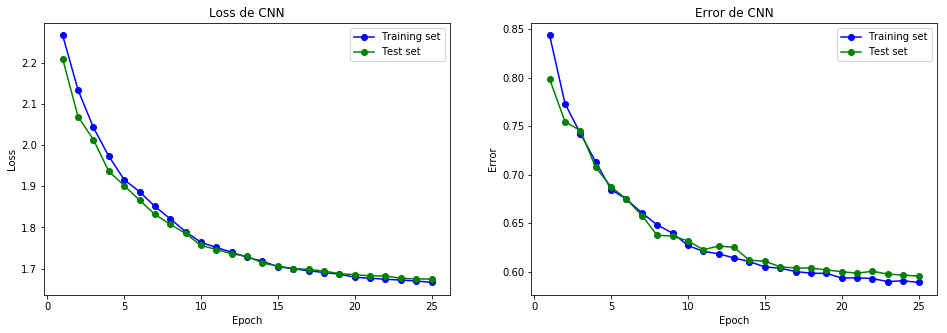

In [60]:
plot(model_sgd.history)

In [120]:
plot_model(model, to_file='model_sgd.png', show_shapes=True)

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

Evaluand la red en el test set

In [53]:
score_Sgd = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 18s 2ms/step


In [64]:
print("Cross entropy:", score_Sgd[0])
print("Accuracy: ", score_Sgd[1])

Cross entropy: 1.6743492725372315
Accuracy:  0.4045


e) Entrene la CNN definida en c) utilizando RMSProp durante 25 epochs. Elija la función de pérdida más apropiada para este problema. Construya finalmente un gráfico que muestre los errores de entrenamiento, validación y pruebas como función del número de epochs.

In [65]:
from keras.optimizers import SGD, rmsprop
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy' ,metrics=['acc'])
model_rmsprop = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test),shuffle=True)

Train on 45000 samples, validate on 10000 samples
Epoch 1/25
45000/45000 [==============================] - 197s 4ms/step - loss: 3.2587 - acc: 0.3152 - val_loss: 1.6329 - val_acc: 0.4052
Epoch 2/25
45000/45000 [==============================] - 191s 4ms/step - loss: 1.5814 - acc: 0.4367 - val_loss: 1.5274 - val_acc: 0.4534
Epoch 3/25
45000/45000 [==============================] - 186s 4ms/step - loss: 1.4341 - acc: 0.4903 - val_loss: 1.4996 - val_acc: 0.4648
Epoch 4/25
45000/45000 [==============================] - 187s 4ms/step - loss: 1.3045 - acc: 0.5364 - val_loss: 1.4671 - val_acc: 0.4829
Epoch 5/25
45000/45000 [==============================] - 186s 4ms/step - loss: 1.1741 - acc: 0.5851 - val_loss: 1.5104 - val_acc: 0.4831
Epoch 6/25
45000/45000 [==============================] - 187s 4ms/step - loss: 1.0444 - acc: 0.6319 - val_loss: 1.5656 - val_acc: 0.4843
Epoch 7/25
45000/45000 [==============================] - 187s 4ms/step - loss: 0.9096 - acc: 0.6831 - val_loss: 1.5868 - 

In [79]:
score_msprop = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 13s 1ms/step


In [90]:
print(x_val.shape)
print(y_val.shape)

print(y_train.shape)
print(y_test.shape)

(5000, 32, 32, 3)
(5000, 10, 10, 10)
(45000, 10, 10, 10)
(10000, 10, 10, 10)


In [91]:
model_rmsprop_val = model.fit(x_val, y_val, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test),shuffle=True)

ValueError: Error when checking target: expected activation_4 to have 2 dimensions, but got array with shape (5000, 10, 10, 10)